Выполнил: Григорьев П.К.

Исходные данные: https://www.kaggle.com/datasets/engamohammed/production-timing/discussion/496539

data actual time work 2023.csv

Задача: Вариант 3. Анализ производственных показателей на заводе.
Сравните производственные показатели двух отделов за последний год. Где наблюдается наибольшая эффективность?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install duckdb jupysql duckdb-engine --upgrade --quiet

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

import duckdb
import pandas as pd
import altair as alt

conn = duckdb.connect()

from google.colab import auth
auth.authenticate_user()
print('Authenticated')
from google.colab import drive
drive.mount('/content/drive')

Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%sql duckdb://

In [3]:
input_df = pd.read_csv('/content/drive/MyDrive/data actual time work 2023.csv')
input_df.head()

,Posting Date,Order No.,Item,Quantity,Department,Time,Direct \nCost,Overhead \nCost,Departement Code,Sales order
0,1/30/2023,POR-11040723,Sofa,15.75,Upholstery,235.0,5405.28,6814.72,PRODUCTION,SSO-12123384
1,1/30/2023,POR-11041006,Sofa,12.28,Upholstery,170.0,3910.20,4929.80,PRODUCTION,SSO-12123384
2,1/30/2023,POR-11041007,Sofa,2.47,Upholstery,35.0,805.04,1014.96,PRODUCTION,SSO-12123384
3,1/30/2023,POR-11041682,Rectangular Dining Table,1.00,Painting,95.0,2375.00,3515.00,PRODUCTION,SSO-12133564
4,1/30/2023,POR-11041805,TV unit,1.00,Painting,190.0,4750.00,7030.00,PRODUCTION,PROD-PAINTING-0002


In [4]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11033 entries, 0 to 11032
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Posting Date      11033 non-null  object 
 1   Order No.         11033 non-null  object 
 2   Item              11033 non-null  object 
 3   Quantity          11033 non-null  float64
 4   Department        11033 non-null  object 
 5   Time              11033 non-null  float64
 6   Direct 
Cost      11033 non-null  float64
 7   Overhead 
Cost    11033 non-null  float64
 8   Departement Code  11033 non-null  object 
 9   Sales order       11033 non-null  object 
dtypes: float64(4), object(6)
memory usage: 862.1+ KB


In [5]:
input_df.describe()

,Quantity,Time,Direct \nCost,Overhead \nCost
count,11033.000000,11033.000000,11033.000000,11033.000000
mean,11.757926,47.268491,1074.282201,1495.972165
std,60.904721,202.490541,4883.047788,6958.167043
min,0.510000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,45.000000,37.000000
50%,2.000000,12.000000,299.990000,370.000000
75%,5.000000,40.000000,1000.000000,1304.950000
max,1500.000000,10000.000000,250000.000000,370000.000000


Наблюдаются возможные выбросы в данных. Нужно изучить подозрительные записи, так как заводу могла просто быть заказана очень большая партия изделий.

In [6]:
input_df[input_df['Quantity'] > 1000]

,Posting Date,Order No.,Item,Quantity,Department,Time,Direct \nCost,Overhead \nCost,Departement Code,Sales order
7517,9/28/2023,POR-11045758,Panels,1454.0,Painting,3000.0,75000.00,111000.00,PRODUCTION,SSO-12160426
7518,9/28/2023,POR-11045758,Panels,1454.0,Assembly,3576.0,89400.00,132312.00,PRODUCTION,SSO-12160426
7519,9/28/2023,POR-11045758,Panels,1454.0,Veneer,300.0,7500.00,11100.00,PRODUCTION,SSO-12160426
7520,9/28/2023,POR-11045758,Panels,1454.0,machine,65.0,112.00,74.00,PRODUCTION,SSO-12160426
7566,9/28/2023,POR-11046064,Dividers,1454.0,Painting,30.0,750.00,1110.00,PRODUCTION,SSO-12160426
7567,9/28/2023,POR-11046064,Dividers,1454.0,Assembly,50.0,1250.00,1850.00,PRODUCTION,SSO-12160426
7568,9/28/2023,POR-11046064,Dividers,1454.0,machine,73.0,688.99,481.01,PRODUCTION,SSO-12160426
9563,12/18/2023,POR-11046763,Skirting,1500.0,machine,24.5,1079.97,666.03,PRODUCTION,PROD-CARPENTRY-0001
9564,12/18/2023,POR-11046763,Skirting,1500.0,Assembly,460.0,250.00,370.00,PRODUCTION,PROD-CARPENTRY-0004
9929,12/30/2023,POR-11046763,Skirting,1500.0,Painting,500.0,12500.00,18500.00,PRODUCTION,PROD-PAINTING-0002


Сравним стоимость и затраты времени на покрасу панелей в обычной партии и в необычно большой, чтобы понять, реальны ли данные.

In [7]:
input_df[input_df['Item'] == 'Panels']

,Posting Date,Order No.,Item,Quantity,Department,Time,Direct \nCost,Overhead \nCost,Departement Code,Sales order
519,1/31/2023,POR-11043438,Panels,7.88,machine,0.50,26.50,18.50,PRODUCTION,PROD-CARPENTRY-0001
520,1/31/2023,POR-11043438,Panels,7.88,Assembly,20.00,500.00,740.00,PRODUCTION,PROD-CARPENTRY-0004
796,2/1/2023,POR-11043390,Panels,23.00,machine,0.58,30.74,21.46,PRODUCTION,PROD-CARPENTRY-0001
797,2/1/2023,POR-11043390,Panels,23.00,Assembly,50.00,1250.00,1850.00,PRODUCTION,PROD-CARPENTRY-0004
801,2/1/2023,POR-11043429,Panels,7.04,machine,0.25,13.25,9.25,PRODUCTION,PROD-CARPENTRY-0001
...,...,...,...,...,...,...,...,...,...,...
10011,12/31/2023,POR-11041002,Panels,13.00,Painting,20.00,500.00,740.00,PRODUCTION,SSO-12123384
10012,12/31/2023,POR-11041002,Panels,13.00,Assembly,20.00,500.00,740.00,PRODUCTION,SSO-12123384
10015,12/31/2023,POR-11041004,Panels,2.00,Painting,20.00,500.00,740.00,PRODUCTION,SSO-12123384
10053,12/31/2023,POR-11044013,Panels,173.70,Painting,400.00,10000.00,14800.00,PRODUCTION,SSO-12150609


По заказу POR-11041002	можно увидеть, что на покраску панели в обычной партии уходит 1,5 временных у.е. и 38,4 денежных. В необычно большой партии (заказ POR-11045758) затраты составляют 2 и 51,58 у.е. соответственно. Значения в большой партии больше, но в разумных пределах, данную ситуацию можно объяснить тем, что на обработку настолько больших партий уходит большее количество времени и усилий.

Записи по заказу POR-11046064	тоже выглядят реалистично.


С другой стороны, записи по заказу POR-11046763	вызывают подозрение. Необходимо изучить данные по другим заказам, связанным с изделием Skirting (плинтус).

In [8]:
input_df[(input_df['Item'] == 'Skirting') & (input_df['Department'] == 'Assembly')]

,Posting Date,Order No.,Item,Quantity,Department,Time,Direct \nCost,Overhead \nCost,Departement Code,Sales order
3218,4/30/2023,POR-11044537,Skirting,65.00,Assembly,110.0,1500.0,2220.0,PRODUCTION,SSO-12151143
3512,5/4/2023,POR-11044452,Skirting,8.60,Assembly,10.0,125.0,185.0,PRODUCTION,SSO-12132554
4162,5/31/2023,POR-11044538,Skirting,39.00,Assembly,130.0,1250.0,1850.0,PRODUCTION,SSO-12151143
4164,5/31/2023,POR-11044540,Skirting,32.00,Assembly,80.0,1250.0,1850.0,PRODUCTION,SSO-12151143
4402,6/1/2023,POR-11044528,Skirting,18.50,Assembly,130.0,1250.0,1850.0,PRODUCTION,SSO-12151143
4405,6/1/2023,POR-11044532,Skirting,22.50,Assembly,45.0,1125.0,1665.0,PRODUCTION,SSO-12151143
4408,6/1/2023,POR-11044534,Skirting,25.00,Assembly,60.0,1500.0,2220.0,PRODUCTION,SSO-12151143
4411,6/1/2023,POR-11044539,Skirting,29.50,Assembly,50.0,1250.0,1850.0,PRODUCTION,SSO-12151143
5302,7/20/2023,POR-11044530,Skirting,19.10,Assembly,45.0,1125.0,1665.0,PRODUCTION,SSO-12151143
5425,7/20/2023,POR-11045300,Skirting,61.00,Assembly,154.0,2375.0,3515.0,PRODUCTION,SSO-12151143


На сборку 1 изделия плинтуса в обычной партии уходит 0,3 временной у.е. и 10 денежных в рамках прямых затрат. В большой партии временные затраты сопоставимы (в пропорции), а денежные значительно ниже, но если изучить данные внимательнее, можно сделать вывод, что прямые затраты в данном случае зависят не от количества изделий, а от времени работы машин. Если сравнить значения по этим показателям, денежные затраты всё равно не выглядят реалистично и выбиваются из общей картины. Исключим записи по заказу POR-11046763	из датафрейма.

In [9]:
df = input_df[input_df['Order No.'] != 'POR-11046763']

Теперь когда логика работы завода понятна лучше, можно переименовать поля для удобства работы и создать рассчетные поля для лучшего поиска выбросов.

In [10]:
df = df.rename(columns={"Direct \nCost": "Direct Cost", "Overhead \nCost": "Overhead Cost", "Sales order": "Sales Order"})

In [11]:
df_calc = df
df_calc["DC/Time"] = df_calc["Direct Cost"] / df_calc["Time"]
df_calc["OC/Time"] = df_calc["Overhead Cost"] / df_calc["Time"]
df_calc["DC/Quantity"] = df_calc["Direct Cost"] / df_calc["Quantity"]
df_calc["OC/Quantity"] = df_calc["Overhead Cost"] /df_calc["Quantity"]
df_calc["Time/Quantity"] = df_calc["Time"] / df_calc["Quantity"]
df_calc

,Posting Date,Order No.,Item,Quantity,Department,Time,Direct Cost,Overhead Cost,Departement Code,Sales Order,DC/Time,OC/Time,DC/Quantity,OC/Quantity,Time/Quantity
0,1/30/2023,POR-11040723,Sofa,15.75,Upholstery,235.00,5405.28,6814.72,PRODUCTION,SSO-12123384,23.001191,28.998809,343.192381,432.680635,14.920635
1,1/30/2023,POR-11041006,Sofa,12.28,Upholstery,170.00,3910.20,4929.80,PRODUCTION,SSO-12123384,23.001176,28.998824,318.420195,401.449511,13.843648
2,1/30/2023,POR-11041007,Sofa,2.47,Upholstery,35.00,805.04,1014.96,PRODUCTION,SSO-12123384,23.001143,28.998857,325.927126,410.914980,14.170040
3,1/30/2023,POR-11041682,Rectangular Dining Table,1.00,Painting,95.00,2375.00,3515.00,PRODUCTION,SSO-12133564,25.000000,37.000000,2375.000000,3515.000000,95.000000
4,1/30/2023,POR-11041805,TV unit,1.00,Painting,190.00,4750.00,7030.00,PRODUCTION,PROD-PAINTING-0002,25.000000,37.000000,4750.000000,7030.000000,190.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11028,12/31/2023,POR-11047669,Arm chair,1.00,Assembly,20.00,500.00,740.00,PRODUCTION,PROD-CARPENTRY-0004,25.000000,37.000000,500.000000,740.000000,20.000000
11029,12/31/2023,POR-11047726,Shelves,2.00,Painting,6.30,25.00,37.00,PRODUCTION,MAN-CTLPAC-0001,3.968254,5.873016,12.500000,18.500000,3.150000
11030,12/31/2023,POR-11047726,Shelves,2.00,Assembly,10.00,250.00,370.00,PRODUCTION,MAN-CTLPAC-0001,25.000000,37.000000,125.000000,185.000000,5.000000
11031,12/31/2023,POR-11047726,Shelves,2.00,Veneer,1.00,25.00,37.00,PRODUCTION,MAN-CTLPAC-0001,25.000000,37.000000,12.500000,18.500000,0.500000


In [12]:
df_calc.describe()

,Quantity,Time,Direct Cost,Overhead Cost,DC/Time,OC/Time,DC/Quantity,OC/Quantity,Time/Quantity
count,11030.000000,11030.000000,11030.000000,11030.000000,11027.000000,11027.000000,11030.000000,11030.000000,11030.000000
mean,11.353146,47.192091,1073.320539,1494.607876,23.398811,28.772090,307.816297,430.726125,13.782753
std,55.747327,202.433914,4882.493452,6957.216608,11.285798,12.683073,923.376267,1224.179871,38.527144
min,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,45.000000,37.000000,23.001111,22.769231,15.000000,14.230962,1.000000
50%,2.000000,12.000000,299.990000,370.000000,25.000000,37.000000,110.715985,148.000000,5.000000
75%,5.000000,40.000000,1000.000000,1302.477500,25.000000,37.000000,345.017500,453.061224,15.000000
max,1454.000000,10000.000000,250000.000000,370000.000000,62.000000,37.048544,34501.790000,43498.210000,1500.000000


Рассмотрим нулевые значения: время может быть равно 0, если работа не требуется но есть в маршруте изделия - это сказано на странице датасета на Kaggle. Прямые и косвенные затраты могут быть равны 0, если изделие находится в отделе Control&Packing.

In [13]:
df_calc[(df_calc['Department'] == 'Control&Packing')]

,Posting Date,Order No.,Item,Quantity,Department,Time,Direct Cost,Overhead Cost,Departement Code,Sales Order,DC/Time,OC/Time,DC/Quantity,OC/Quantity,Time/Quantity
23,1/30/2023,POR-11042501,Round side table,1.0,Control&Packing,60.00,0.0,0.0,PRODUCTION,SSO-12142594,0.0,0.0,0.0,0.0,60.000000
85,1/31/2023,POR-11042448,Banquette,1.0,Control&Packing,0.50,0.0,0.0,PRODUCTION,SSO-12141928,0.0,0.0,0.0,0.0,0.500000
159,1/31/2023,POR-11042634,Rectangular Center Table,8.0,Control&Packing,1.00,0.0,0.0,PRODUCTION,SSO-12142354,0.0,0.0,0.0,0.0,0.125000
160,1/31/2023,POR-11042635,Square Side Table,7.0,Control&Packing,1.00,0.0,0.0,PRODUCTION,SSO-12142354,0.0,0.0,0.0,0.0,0.142857
168,1/31/2023,POR-11042723,Sofa,3.0,Control&Packing,1.00,0.0,0.0,PRODUCTION,MAN-CTLPAC-0001,0.0,0.0,0.0,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10805,12/31/2023,POR-11047472,Single Door,1.0,Control&Packing,35.00,0.0,0.0,PRODUCTION,MAN-CTLPAC-0001,0.0,0.0,0.0,0.0,35.000000
10808,12/31/2023,POR-11047473,Door accessory,160.0,Control&Packing,0.00,0.0,0.0,PRODUCTION,MAN-CTLPAC-0001,NaN,NaN,0.0,0.0,0.000000
10811,12/31/2023,POR-11047474,Door accessory,70.0,Control&Packing,0.00,0.0,0.0,PRODUCTION,SSO-12168987,NaN,NaN,0.0,0.0,0.000000
10814,12/31/2023,POR-11047475,Door accessory,5.0,Control&Packing,0.00,0.0,0.0,PRODUCTION,SSO-12168987,NaN,NaN,0.0,0.0,0.000000


In [14]:
df_calc[(df_calc['Direct Cost'] == 0) & (df_calc['Department'] != 'Control&Packing')]

,Posting Date,Order No.,Item,Quantity,Department,Time,Direct Cost,Overhead Cost,Departement Code,Sales Order,DC/Time,OC/Time,DC/Quantity,OC/Quantity,Time/Quantity
409,1/31/2023,POR-11043340,Sofa,3.0,Painting,6.0,0.0,0.0,PRODUCTION,SSO-12145496,0.0,0.0,0.0,0.0,2.000000
579,2/1/2023,POR-11039563,Headboard,1.0,Upholstery,50.0,0.0,0.0,PRODUCTION,SSO-12118882,0.0,0.0,0.0,0.0,50.000000
630,2/1/2023,POR-11040141,Arm chair,3.0,Painting,12.0,0.0,0.0,PRODUCTION,SSO-12119580,0.0,0.0,0.0,0.0,4.000000
648,2/1/2023,POR-11041880,Buffet,1.0,Upholstery,12.0,0.0,0.0,PRODUCTION,SSO-12142139,0.0,0.0,0.0,0.0,12.000000
680,2/1/2023,POR-11042511,Sofa,2.0,Upholstery,90.0,0.0,0.0,PRODUCTION,SSO-12142594,0.0,0.0,0.0,0.0,45.000000
732,2/1/2023,POR-11042908,Rectangular Center Table,1.0,Upholstery,6.0,0.0,0.0,PRODUCTION,PROD-UPHOLSTERY-0002,0.0,0.0,0.0,0.0,6.000000
1160,3/21/2023,POR-11040127,Stool,1.0,Painting,4.0,0.0,0.0,PRODUCTION,SSO-12119580,0.0,0.0,0.0,0.0,4.000000
1161,3/21/2023,POR-11040128,Stool,1.0,Painting,4.0,0.0,0.0,PRODUCTION,SSO-12119580,0.0,0.0,0.0,0.0,4.000000
1167,3/21/2023,POR-11042621,Sofa,1.0,Painting,5.0,0.0,0.0,PRODUCTION,SSO-12142733,0.0,0.0,0.0,0.0,5.000000
1209,3/21/2023,POR-11043296,Arm chair,2.0,Painting,14.0,0.0,0.0,PRODUCTION,PROD-PAINTING-0001,0.0,0.0,0.0,0.0,7.000000


In [15]:
condition = (df_calc['Direct Cost'] == 0) & (df_calc['Department'] != 'Control&Packing')
df_calc = df_calc.drop(df_calc[condition].index)

Изучим выбросы в данных

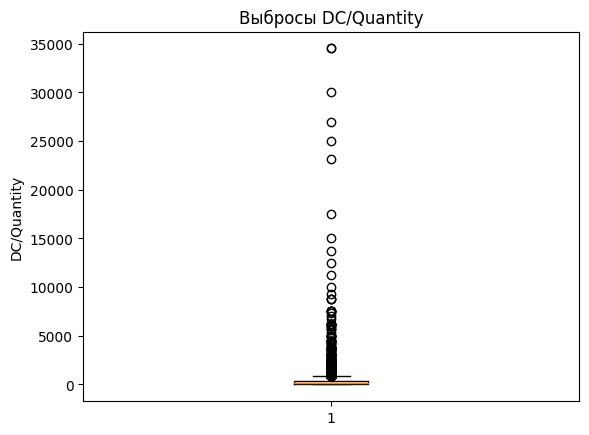

In [16]:
plt.boxplot(df_calc['DC/Quantity'])
plt.title('Выбросы DC/Quantity')
plt.ylabel('DC/Quantity')
plt.show()

In [17]:
q95 = df_calc['DC/Quantity'].quantile(0.95)
print(f"95-й квантиль: {q95}")

95-й квантиль: 1125.0


In [18]:
df_calc1 = df_calc[df_calc['DC/Quantity'] <= q95]

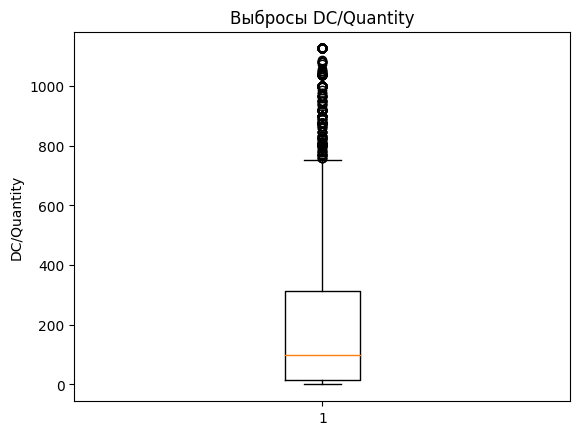

In [19]:
plt.boxplot(df_calc1['DC/Quantity'])
plt.title('Выбросы DC/Quantity')
plt.ylabel('DC/Quantity')
plt.show()

In [20]:
df_calc1.describe()

,Quantity,Time,Direct Cost,Overhead Cost,DC/Time,OC/Time,DC/Quantity,OC/Quantity,Time/Quantity
count,10583.000000,10583.000000,10583.000000,10583.000000,10580.000000,10580.000000,10583.000000,10583.000000,10583.000000
mean,11.739795,40.853880,901.538991,1262.983827,23.326482,28.545980,208.509782,294.917844,9.884145
std,56.871604,176.707939,4139.620033,5911.264459,11.361985,12.780862,261.689518,379.147518,17.205524
min,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.660000,40.200000,37.000000,23.001071,20.923832,15.000000,12.580000,1.000000
50%,2.000000,11.000000,250.000000,370.000000,25.000000,37.000000,100.000000,148.000000,4.761905
75%,5.200000,36.000000,750.000000,1110.000000,25.000000,37.000000,312.500000,405.985000,14.000000
max,1454.000000,10000.000000,250000.000000,370000.000000,60.067961,37.048544,1125.000000,1665.000000,602.000000


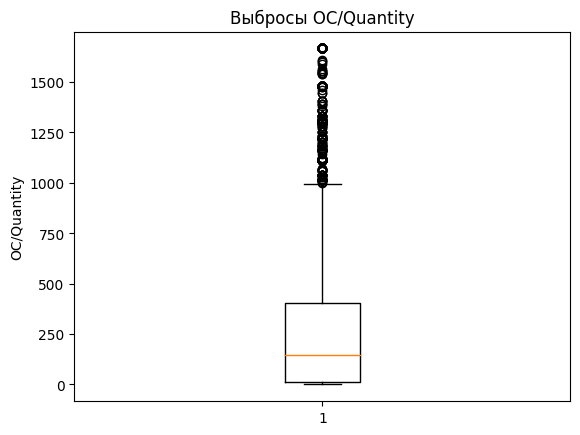

In [21]:
plt.boxplot(df_calc1['OC/Quantity'])
plt.title('Выбросы OC/Quantity')
plt.ylabel('OC/Quantity')
plt.show()

In [22]:
q95 = df_calc1['OC/Quantity'].quantile(0.95)
print(f"95-й квантиль: {q95}")

95-й квантиль: 1110.0


In [23]:
df_calc2 = df_calc1[df_calc1['OC/Quantity'] <= q95]

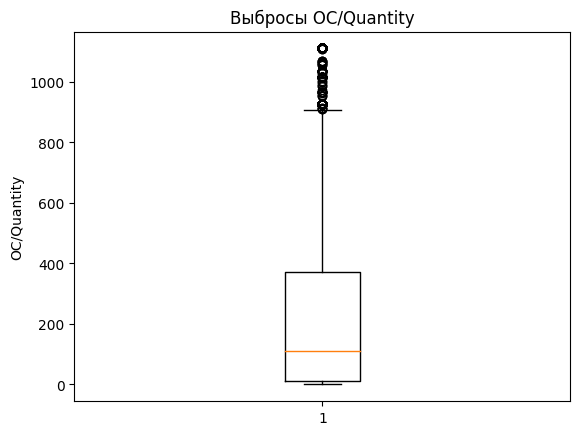

In [24]:
plt.boxplot(df_calc2['OC/Quantity'])
plt.title('Выбросы OC/Quantity')
plt.ylabel('OC/Quantity')
plt.show()

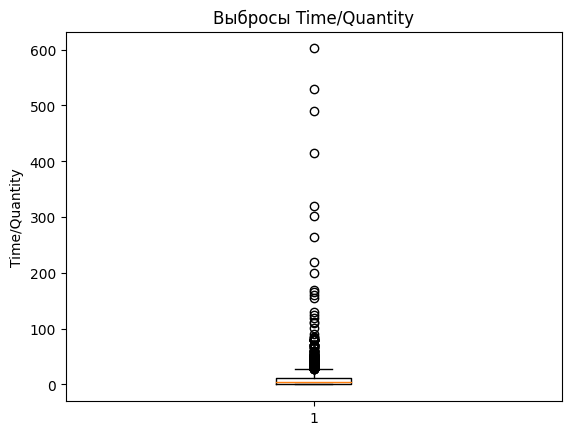

In [25]:
plt.boxplot(df_calc2['Time/Quantity'])
plt.title('Выбросы Time/Quantity')
plt.ylabel('Time/Quantity')
plt.show()

In [26]:
q95 = df_calc2['Time/Quantity'].quantile(0.95)
print(f"95-й квантиль: {q95}")

95-й квантиль: 27.977777777777696


In [27]:
df_calc3 = df_calc2[df_calc2['Time/Quantity'] <= q95]

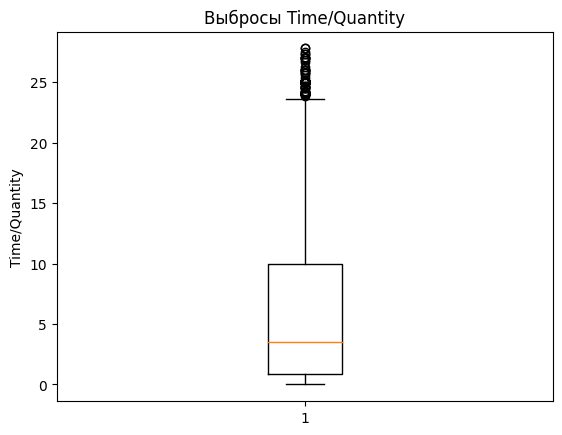

In [28]:
plt.boxplot(df_calc3['Time/Quantity'])
plt.title('Выбросы Time/Quantity')
plt.ylabel('Time/Quantity')
plt.show()

Добавим дополнительные показатели, которые можно расчитать на основании имеющихся данных.

In [29]:
# Правильное название этого показателя - трудоемкость, было переведено как "Labor Costs"
df_calc3 = df_calc3.rename(columns={"Time/Quantity": "Labor Costs"})

In [30]:
df_calc3["Total Cost"] = df_calc3["Direct Cost"] + df_calc3["Overhead Cost"]

Создадим с помощью SQL таблицы для последующей визуализации в Polymatica Dashboards.

In [31]:
df_calc3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9578 entries, 0 to 11032
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Posting Date      9578 non-null   object 
 1   Order No.         9578 non-null   object 
 2   Item              9578 non-null   object 
 3   Quantity          9578 non-null   float64
 4   Department        9578 non-null   object 
 5   Time              9578 non-null   float64
 6   Direct Cost       9578 non-null   float64
 7   Overhead Cost     9578 non-null   float64
 8   Departement Code  9578 non-null   object 
 9   Sales Order       9578 non-null   object 
 10  DC/Time           9575 non-null   float64
 11  OC/Time           9575 non-null   float64
 12  DC/Quantity       9578 non-null   float64
 13  OC/Quantity       9578 non-null   float64
 14  Labor Costs       9578 non-null   float64
 15  Total Cost        9578 non-null   float64
dtypes: float64(10), object(6)
memory usage: 1.2+ M

In [32]:
df_calc3.to_csv('factory_data.csv')

In [33]:
%%sql
create or replace table factory as
from read_csv('factory_data.csv');

,Success


In [34]:
%%sql
SELECT *
FROM factory;

,column00,Posting Date,Order No.,Item,Quantity,Department,Time,Direct Cost,Overhead Cost,Departement Code,Sales Order,DC/Time,OC/Time,DC/Quantity,OC/Quantity,Labor Costs,Total Cost
0,0,2023-01-30,POR-11040723,Sofa,15.75,Upholstery,235.00,5405.28,6814.72,PRODUCTION,SSO-12123384,23.001191,28.998809,343.192381,432.680635,14.920635,12220.0
1,1,2023-01-30,POR-11041006,Sofa,12.28,Upholstery,170.00,3910.20,4929.80,PRODUCTION,SSO-12123384,23.001176,28.998824,318.420195,401.449511,13.843648,8840.0
2,2,2023-01-30,POR-11041007,Sofa,2.47,Upholstery,35.00,805.04,1014.96,PRODUCTION,SSO-12123384,23.001143,28.998857,325.927126,410.914980,14.170040,1820.0
3,5,2023-01-30,POR-11041806,Cladding,12.70,Assembly,80.00,2000.00,2960.00,PRODUCTION,SSO-12133564,25.000000,37.000000,157.480315,233.070866,6.299213,4960.0
4,8,2023-01-30,POR-11041842,Mirror,1.00,Painting,13.00,325.00,481.00,PRODUCTION,SSO-12133564,25.000000,37.000000,325.000000,481.000000,13.000000,806.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,11028,2023-12-31,POR-11047669,Arm chair,1.00,Assembly,20.00,500.00,740.00,PRODUCTION,PROD-CARPENTRY-0004,25.000000,37.000000,500.000000,740.000000,20.000000,1240.0
9574,11029,2023-12-31,POR-11047726,Shelves,2.00,Painting,6.30,25.00,37.00,PRODUCTION,MAN-CTLPAC-0001,3.968254,5.873016,12.500000,18.500000,3.150000,62.0
9575,11030,2023-12-31,POR-11047726,Shelves,2.00,Assembly,10.00,250.00,370.00,PRODUCTION,MAN-CTLPAC-0001,25.000000,37.000000,125.000000,185.000000,5.000000,620.0
9576,11031,2023-12-31,POR-11047726,Shelves,2.00,Veneer,1.00,25.00,37.00,PRODUCTION,MAN-CTLPAC-0001,25.000000,37.000000,12.500000,18.500000,0.500000,62.0


In [35]:
%%sql
ALTER TABLE factory DROP column00;

,Success


In [36]:
%%sql
select * from(
DESCRIBE select * from factory)

,column_name,column_type,null,key,default,extra
0,Posting Date,DATE,YES,None,None,None
1,Order No.,VARCHAR,YES,None,None,None
2,Item,VARCHAR,YES,None,None,None
3,Quantity,DOUBLE,YES,None,None,None
4,Department,VARCHAR,YES,None,None,None
5,Time,DOUBLE,YES,None,None,None
6,Direct Cost,DOUBLE,YES,None,None,None
7,Overhead Cost,DOUBLE,YES,None,None,None
8,Departement Code,VARCHAR,YES,None,None,None
9,Sales Order,VARCHAR,YES,None,None,None


In [37]:
%%sql
SELECT Department,
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY Department
ORDER BY Department

,Department,Orders Count,avg DC/Time,avg OC/Time,avg DC/Quantity,avg OC/Quantity,avg Labor Costs,Total Cost
0,Assembly,2257,23.994,35.511,290.256,429.579,12.082,8796964.24
1,Control&Packing,137,0.672,0.045,9.489,0.438,0.801,1360.00
2,Curtains,525,29.999,37.001,111.230,137.193,3.708,627928.40
3,Painting,1576,22.265,32.952,204.442,302.574,9.028,5954947.95
4,Upholstery,744,21.702,27.361,258.068,325.361,11.985,1870759.45
5,Veneer,1629,24.467,36.211,74.756,110.638,3.103,1090686.02
6,machine,2710,23.848,15.092,21.508,13.522,1.294,806226.23


In [38]:
%%sql
COPY (
SELECT Department,
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY Department
ORDER BY Department
) TO 'departments_indexes.csv' (HEADER, DELIMITER ',');

,Success


In [39]:
%%sql
SELECT "Posting Date",
  Department,
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY "Posting Date", Department
ORDER BY "Posting Date", Department

,Posting Date,Department,Orders Count,avg DC/Time,avg OC/Time,avg DC/Quantity,avg OC/Quantity,avg Labor Costs,Total Cost
0,2023-01-30,Assembly,5,25.000,37.000,275.246,407.364,11.010,12090.00
1,2023-01-30,Painting,9,11.803,17.468,149.131,220.714,7.621,5798.35
2,2023-01-30,Upholstery,22,18.703,23.580,215.880,272.173,12.528,68328.00
3,2023-01-30,machine,1,29.179,34.821,124.010,147.990,4.250,544.00
4,2023-01-31,Assembly,129,24.548,36.331,346.760,513.204,14.211,341248.00
...,...,...,...,...,...,...,...,...,...
415,2023-12-31,Curtains,237,29.999,37.001,128.488,158.478,4.283,158187.00
416,2023-12-31,Painting,158,17.068,25.260,93.054,137.721,5.571,631890.41
417,2023-12-31,Upholstery,38,22.633,28.534,233.507,294.396,10.264,106170.43
418,2023-12-31,Veneer,137,24.567,36.359,95.401,141.193,3.836,102997.50


In [41]:
%%sql
COPY (
SELECT "Posting Date",
  Department,
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY "Posting Date", Department
ORDER BY "Posting Date", Department
) TO 'departments_daily_indexes.csv' (HEADER, DELIMITER ',');

,Success


In [42]:
%%sql
COPY (
SELECT
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
) TO 'factory_indexes.csv' (HEADER, DELIMITER ',');

,Success


In [43]:
%%sql
COPY (
SELECT "Posting Date",
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY "Posting Date"
ORDER BY "Posting Date"
) TO 'factory_daily_indexes.csv' (HEADER, DELIMITER ',');

,Success


In [44]:
%%sql

SELECT EXTRACT(MONTH FROM ("Posting Date")) as Month,
  Department,
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY "Posting Date", Department
ORDER BY "Posting Date", Department



,Month,Department,Orders Count,avg DC/Time,avg OC/Time,avg DC/Quantity,avg OC/Quantity,avg Labor Costs,Total Cost
0,1,Assembly,5,25.000,37.000,275.246,407.364,11.010,12090.00
1,1,Painting,9,11.803,17.468,149.131,220.714,7.621,5798.35
2,1,Upholstery,22,18.703,23.580,215.880,272.173,12.528,68328.00
3,1,machine,1,29.179,34.821,124.010,147.990,4.250,544.00
4,1,Assembly,129,24.548,36.331,346.760,513.204,14.211,341248.00
...,...,...,...,...,...,...,...,...,...
415,12,Curtains,237,29.999,37.001,128.488,158.478,4.283,158187.00
416,12,Painting,158,17.068,25.260,93.054,137.721,5.571,631890.41
417,12,Upholstery,38,22.633,28.534,233.507,294.396,10.264,106170.43
418,12,Veneer,137,24.567,36.359,95.401,141.193,3.836,102997.50


In [45]:
%%sql
COPY (
SELECT EXTRACT(MONTH FROM ("Posting Date")) as Month,
  Department,
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY "Posting Date", Department
ORDER BY "Posting Date", Department
) TO 'departments_monthly_indexes.csv' (HEADER, DELIMITER ',');


,Success


In [46]:
%%sql
COPY (
SELECT EXTRACT(MONTH FROM ("Posting Date")) as Month,
  Department,
  COUNT(1) as "Orders Count",
  ROUND(AVG("DC/Time"), 3) AS "avg DC/Time",
  ROUND(AVG("OC/Time"), 3) AS "avg OC/Time",
  ROUND(AVG("DC/Quantity"), 3) AS "avg DC/Quantity",
  ROUND(AVG("OC/Quantity"), 3) AS "avg OC/Quantity",
  ROUND(AVG("Labor Costs"), 3) AS "avg Labor Costs",
  ROUND(SUM("Total Cost"), 3) AS "Total Cost",
FROM factory
GROUP BY "Posting Date", Department
ORDER BY "Posting Date", Department
) TO 'departments_monthly_indexes.csv' (HEADER, DELIMITER ',');

,Success


Можно приступать к визуализации в Polymatica Dashboards. В задании указао, что необходимо сравнить 2 отдела, этими отделами будут Painting (покраска) и Veneer (отделка) как наиболее близкие по количеству выполненных работ и логике производства на данном заводе.

[Ссылка на дашборд](https://partners.platform.polymatica.ru/dashboard/shared/803?uid=f18506d3-17db-5c45-a98f-223a5515f954)